# Lesson 06
# Peter Lorenz

In this assignment, we build a model to predict whether an individual is a PEP (politically exposed person) based on their banking data.

## 0. Preliminaries

Import the required libraries:

In [9]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

Set global options:

In [2]:
# Display plots inline
%matplotlib inline

# Display multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Suppress scientific notation
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Declare utility functions:

## 1. Read, parse, and pre-process the data
In this section, we read, parse, and pre-process the data.

In [81]:
# Internet location of the data set
url = "https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/Bank%20Data.csv"

# Download the data into a dataframe object
bank_data = pd.read_csv(url)

# Display shape and initial data
bank_data.shape
bank_data.head()

# Examine column types
bank_data.info()

(600, 11)

,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
0,48,FEMALE,INNER_CITY,17546.000,NO,1,NO,NO,NO,NO,YES
1,40,MALE,TOWN,30085.100,YES,3,YES,NO,YES,YES,NO
2,51,FEMALE,INNER_CITY,16575.400,YES,0,YES,YES,YES,NO,NO
3,23,FEMALE,TOWN,20375.400,YES,3,NO,NO,YES,NO,NO
4,57,FEMALE,RURAL,50576.300,YES,0,NO,YES,NO,NO,NO


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          600 non-null    int64  
 1   sex          600 non-null    object 
 2   region       600 non-null    object 
 3   income       600 non-null    float64
 4   married      600 non-null    object 
 5   children     600 non-null    int64  
 6   car          600 non-null    object 
 7   save_act     600 non-null    object 
 8   current_act  600 non-null    object 
 9   mortgage     600 non-null    object 
 10  pep          600 non-null    object 
dtypes: float64(1), int64(2), object(8)
memory usage: 51.7+ KB


First we have to deal with categorical columns, converting these to one-hot-encoded format:

In [82]:
# Use pandas to one-hot encode binary variables, excluding the inverse column
bank_data_enc = pd.get_dummies(bank_data, 
                               columns=["sex", "married", "car", 
                                        "save_act", "current_act", "mortgage", "pep"], 
                               drop_first=True)

# Use pandas to one-hot encode categorical variables, including one column per value
bank_data_enc = pd.get_dummies(bank_data_enc, 
                               columns=["region", "children"])

# Display shape and sample contents
bank_data_enc.shape
bank_data_enc.head()

# Examine column types
bank_data_enc.info()

(600, 17)

,age,income,sex_MALE,married_YES,car_YES,save_act_YES,current_act_YES,mortgage_YES,pep_YES,region_INNER_CITY,region_RURAL,region_SUBURBAN,region_TOWN,children_0,children_1,children_2,children_3
0,48,17546.000,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
1,40,30085.100,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1
2,51,16575.400,0,1,1,1,1,0,0,1,0,0,0,1,0,0,0
3,23,20375.400,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1
4,57,50576.300,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                600 non-null    int64  
 1   income             600 non-null    float64
 2   sex_MALE           600 non-null    uint8  
 3   married_YES        600 non-null    uint8  
 4   car_YES            600 non-null    uint8  
 5   save_act_YES       600 non-null    uint8  
 6   current_act_YES    600 non-null    uint8  
 7   mortgage_YES       600 non-null    uint8  
 8   pep_YES            600 non-null    uint8  
 9   region_INNER_CITY  600 non-null    uint8  
 10  region_RURAL       600 non-null    uint8  
 11  region_SUBURBAN    600 non-null    uint8  
 12  region_TOWN        600 non-null    uint8  
 13  children_0         600 non-null    uint8  
 14  children_1         600 non-null    uint8  
 15  children_2         600 non-null    uint8  
 16  children_3         600 non

One challenge is how to represent the age column in our data set. The column is sequential and, hence, an age of 42 is more related to an age of 41 than, say, an age of 20. Yet the column is also categorical in that a person who is 40 is not in any sense "twice" a person who is 20. It seems preferable to represent age as a series of bins. First we determine the range of ages:

In [83]:
# Display max and min ages
print('Min age is', bank_data_enc['age'].min())
print('Max age is', bank_data_enc['age'].max())

Min age is 18
Max age is 67


The range of ages is essentially the "working" ages from 18 to 67. One straightforward way to bin the data is by decade: 20's, 30's, 40's, 50's, 60's. For convenience, we combine ages 18 and 19 with the 20's.

In [84]:
# Bin age by decade
bank_data_enc['is_twenties'] = np.array((bank_data_enc['age'] >= 18).astype(int) & 
                                        (bank_data_enc['age'] < 30).astype(int))
bank_data_enc['is_thirties'] = np.array((bank_data_enc['age'] >= 30).astype(int) & 
                                        (bank_data_enc['age'] < 40).astype(int))
bank_data_enc['is_forties'] = np.array((bank_data_enc['age'] >= 40).astype(int) & 
                                       (bank_data_enc['age'] < 50).astype(int))
bank_data_enc['is_fifties'] = np.array((bank_data_enc['age'] >= 50).astype(int) & 
                                        (bank_data_enc['age'] < 60).astype(int))
bank_data_enc['is_sixties'] = np.array((bank_data_enc['age'] >= 60).astype(int))

# Display shape and sample contents
bank_data_enc.shape
bank_data_enc.head()

# Examine column types
bank_data_enc.info()

(600, 22)

,age,income,sex_MALE,married_YES,car_YES,save_act_YES,current_act_YES,mortgage_YES,pep_YES,region_INNER_CITY,...,region_TOWN,children_0,children_1,children_2,children_3,is_twenties,is_thirties,is_forties,is_fifties,is_sixties
0,48,17546.000,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,1,0,0
1,40,30085.100,1,1,1,0,1,1,0,0,...,1,0,0,0,1,0,0,1,0,0
2,51,16575.400,0,1,1,1,1,0,0,1,...,0,1,0,0,0,0,0,0,1,0
3,23,20375.400,0,1,0,0,1,0,0,0,...,1,0,0,0,1,1,0,0,0,0
4,57,50576.300,0,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                600 non-null    int64  
 1   income             600 non-null    float64
 2   sex_MALE           600 non-null    uint8  
 3   married_YES        600 non-null    uint8  
 4   car_YES            600 non-null    uint8  
 5   save_act_YES       600 non-null    uint8  
 6   current_act_YES    600 non-null    uint8  
 7   mortgage_YES       600 non-null    uint8  
 8   pep_YES            600 non-null    uint8  
 9   region_INNER_CITY  600 non-null    uint8  
 10  region_RURAL       600 non-null    uint8  
 11  region_SUBURBAN    600 non-null    uint8  
 12  region_TOWN        600 non-null    uint8  
 13  children_0         600 non-null    uint8  
 14  children_1         600 non-null    uint8  
 15  children_2         600 non-null    uint8  
 16  children_3         600 non

We lose some information concerning the sequential nature of the data, but avoid the meaninglessness of implying that numerical operations apply to ages. We now drop the original age column:

In [85]:
# Drop age column
bank_data_enc = bank_data_enc.drop(['age'], axis=1)

# Display shape and sample contents
bank_data_enc.shape
bank_data_enc.head()

# Examine column types
bank_data_enc.info()

(600, 21)

,income,sex_MALE,married_YES,car_YES,save_act_YES,current_act_YES,mortgage_YES,pep_YES,region_INNER_CITY,region_RURAL,...,region_TOWN,children_0,children_1,children_2,children_3,is_twenties,is_thirties,is_forties,is_fifties,is_sixties
0,17546.000,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,1,0,0
1,30085.100,1,1,1,0,1,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
2,16575.400,0,1,1,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
3,20375.400,0,1,0,0,1,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
4,50576.300,0,1,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   income             600 non-null    float64
 1   sex_MALE           600 non-null    uint8  
 2   married_YES        600 non-null    uint8  
 3   car_YES            600 non-null    uint8  
 4   save_act_YES       600 non-null    uint8  
 5   current_act_YES    600 non-null    uint8  
 6   mortgage_YES       600 non-null    uint8  
 7   pep_YES            600 non-null    uint8  
 8   region_INNER_CITY  600 non-null    uint8  
 9   region_RURAL       600 non-null    uint8  
 10  region_SUBURBAN    600 non-null    uint8  
 11  region_TOWN        600 non-null    uint8  
 12  children_0         600 non-null    uint8  
 13  children_1         600 non-null    uint8  
 14  children_2         600 non-null    uint8  
 15  children_3         600 non-null    uint8  
 16  is_twenties        600 non

Next we extract the target variable:

In [86]:
# Extract and reserve the target column
is_pep = np.array(bank_data_enc['pep_YES'].values)
bank_data_enc = bank_data_enc.drop(['pep_YES'], axis=1)

We can now proceed to exploratory analysis.

## 2. Perform exploratory analysis
In this section, we perform a brief exploratory analysis, beginning with an analysis of column distributions.
### Column distributions
Here we examine the column distributions per column.

#### Income

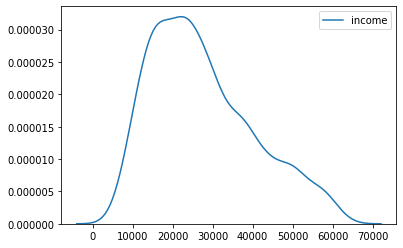

In [87]:
sns.kdeplot(bank_data_enc['income'], bw = 3000)

We find that income is positively skewed with a peak around 20K.

#### Sex

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Is Male?')]

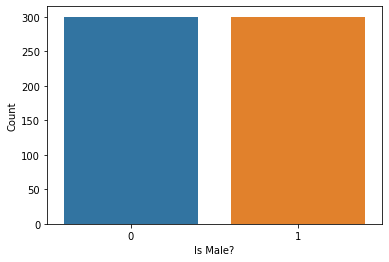

In [88]:
# Plot distribution by sex
ax = sns.countplot(x='sex_MALE', data=bank_data_enc)
ax.set(xlabel='Is Male?', ylabel='Count')

The data set has an equal number of males and females.

#### Age

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Age Group')]

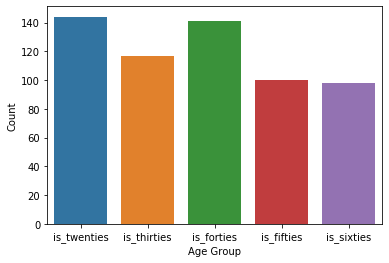

In [91]:
# Plot distribution by age group
df = pd.melt(bank_data_enc[['is_twenties', 'is_thirties', 'is_forties', 'is_fifties', 'is_sixties']])
ax = sns.countplot(data=df.loc[df['value']!=0], x='variable')
ax.set(xlabel='Age Group', ylabel='Count')

The age groups are fairly evenly distributed, with most customers in their twenties or forties (note, however, that the twenties group also includes 18 and 19 year olds). Fewer customers are in their fifties and sixties respectively.

#### Region Category

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Region Category')]

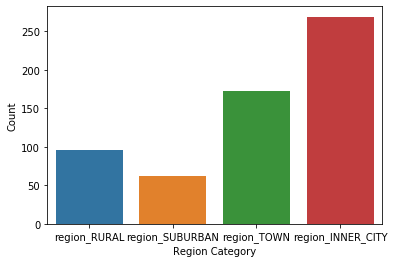

In [93]:
# Plot distribution by region
df = pd.melt(bank_data_enc[['region_RURAL', 'region_SUBURBAN', 'region_TOWN', 'region_INNER_CITY']])
ax = sns.countplot(data=df.loc[df['value']!=0], x='variable')
ax.set(xlabel='Region Category', ylabel='Count')

The plot of customers by region shows that most live in the inner city followed by towns, while fewer live in rural areas and still fewer in suburban areas.

#### Number of Children

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Number of children')]

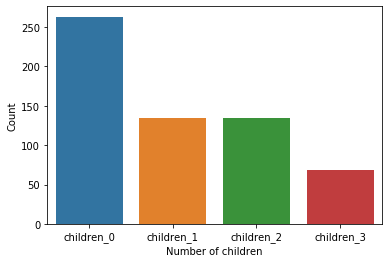

In [94]:
# Plot distribution by number of children
df = pd.melt(bank_data_enc[['children_0', 'children_1', 'children_2', 'children_3']])
ax = sns.countplot(data=df.loc[df['value']!=0], x='variable')
ax.set(xlabel='Number of children', ylabel='Count')

Most customers have no children, while about half of the number with no children have one or two children respectively. The fewest number of customers have three children.

#### Car Ownership

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Owns a car?')]

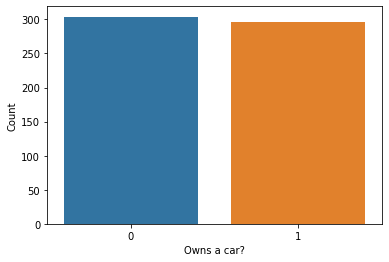

In [95]:
# Plot distribution by car ownership
ax = sns.countplot(x='car_YES', data=bank_data_enc)
ax.set(xlabel='Owns a car?', ylabel='Count')

Approximately equal numbers of customers own a car as do not own a car.

### Account and Mortgage Status

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Account and Mortgage Status')]

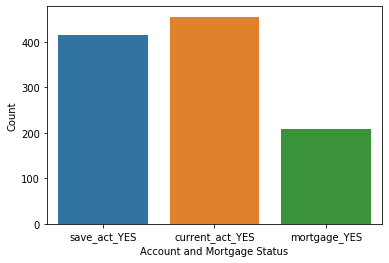

In [96]:
# Plot distribution by account ownership and possession of a mortgage
df = pd.melt(bank_data_enc[['save_act_YES', 'current_act_YES', 'mortgage_YES']])
ax = sns.countplot(data=df.loc[df['value']!=0], x='variable')

ax.set(xlabel='Account and Mortgage Status', ylabel='Count')

Roughly two thirds of customers have a savings account, while slightly more have a current account. Roughly one third has a mortgage.

#### PEP Status

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Is Politically Exposed?')]

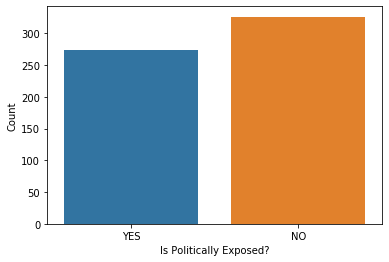

In [99]:
# Plot distribution by PEP status
ax = sns.countplot(x='pep', data=bank_data)
ax.set(xlabel='Is Politically Exposed?', ylabel='Count')

Interestingly, about equal numbers of the banks customers have political exposure. Given these roughly proportionate outcomes, it is unnecessary to balance the data set.

## 3. Compare the performance of decision tree and random forest approaches
In this section, we compare the performance between a decision tree and a random forest approach by assessing the accuracy of each model.

## 4. Graph structure of the decision tree
In this section, we graph the structure of our decision tree.

## 5. Graph the confusion matrix of your random forest model
In this section, we graph the confusion matrix of our random forest model.